In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
from masks import SegmentationToDetectionDataset_CV2
from masks import COLORS
from torchvision.ops import _box_convert

1.10.2 False


In [2]:
batch_size = 1
# Choose whether to start indexing categories with 0 or with 1.
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 1

In [3]:
# from masks import transform


In [4]:
import albumentations as A
import cv2
# Add transforms in the code later
transform = A.Compose([
    # A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

In [5]:
from torch.utils.data import DataLoader
train_path = "/home/francis/Documents/Atom360/code/Dataset/buildings/Building dataset/dataset"
train_data = SegmentationToDetectionDataset_CV2(train_path, transforms=transform)
# valid_data = SegmentationToDetectionDataset(valid_path, transform=transform)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
print("len(train_data)",len(train_data), "len(train_loader)", len(train_loader))

len(train_data) 1443 len(train_loader) 1443


boxes before A [tensor([0.8304, 0.6525, 0.0585, 0.1512]), tensor([0.4087, 0.0676, 0.4851, 0.7361])]
boxes after A tensor([[0.8304, 0.6525, 0.0585, 0.1512],
        [0.4087, 0.0676, 0.4851, 0.7361]])
Label: tensor([1, 1])


<ipython-input-12-e0e1e5c451fe>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drawn_boxes = draw_bounding_boxes(torch.tensor(img.clone().detach()*255, dtype=torch.uint8), boxes.clone().detach(), colors="red")


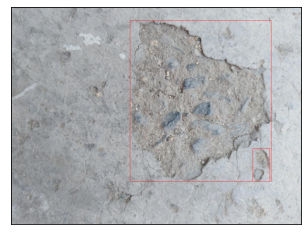

In [12]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from albumentations.augmentations.bbox_utils import denormalize_bbox
from masks import show

train_features, train_labels = next(iter(train_loader))
img = train_features[0].squeeze()
label = train_labels['labels'][0]
# plt.imshow(img.permute(1,2,0), cmap="gray")
# plt.show()
boxes = train_labels['boxes'][0]
for i, box in enumerate(boxes):
    x,y,w,h = torch.tensor(denormalize_bbox(box,img.shape[1], img.shape[2]))
    boxes[i] = torch.tensor([x,y,w,h])
# bbox = denormalize_bbox(train_labels['boxes'])
# boxes = torch.stack(boxes)
for i, box in enumerate(boxes):
    boxes[i] = _box_convert._box_xywh_to_xyxy(box)

drawn_boxes = draw_bounding_boxes(torch.tensor(img.clone().detach()*255, dtype=torch.uint8), boxes.clone().detach(), colors="red")
show(drawn_boxes)
print(f"Label: {label}")

In [8]:
boxes

tensor([[507., 798., 573., 918.],
        [552., 561., 608., 652.],
        [608., 288., 676., 364.]])

In [10]:
train_labels

{'boxes': [tensor([[868.0000,   0.0000, 944.0000, 395.0000]]),
  tensor([[0.6337, 0.0000, 0.2537, 0.1803]]),
  tensor([[0.2947, 0.0000, 0.2989, 0.3591]]),
  tensor([[0.0000, 0.0000, 0.2042, 0.3545]]),
  tensor([[0.5842, 0.2500, 0.1621, 0.1591]])],
 'labels': tensor([[0, 0, 0, 0, 1]])}

In [8]:
img.shape

torch.Size([3, 608, 812])

In [9]:
# Get pretrained weights
# checkpoint = torch.hub.load_state_dict_from_url(
#             url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
#             map_location='cpu',
#             check_hash=True)

# # Remove class weights
# del checkpoint["model"]["class_embed.weight"]
# del checkpoint["model"]["class_embed.bias"]
# del checkpoint["model"]["query_embed.weight"]
# # Save
# torch.save(checkpoint, 'detr-r50_no-class-head.pth')

In [10]:
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 3

  finetuned_classes = ['spall', 'rebar', 'crack']

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 4

  finetuned_classes = ['N/A', 'spall', 'rebar', 'crack']

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 1
Parameter num_classes: 4
Fine-tuned classes: ['N/A', 'spall', 'rebar', 'crack']


In [11]:
!python main_detr.py \
  --dataset_file "building" \
  --data_path "/home/francis/Documents/Atom360/code/Dataset/buildings/Building dataset/dataset" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10 \
  --batch_size 1

Not using distributed mode
git:
  sha: 47ab9ed371be6328519cd99a8349bd67a299a429, status: has uncommited changes, branch: main

Namespace(aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, data_path='/home/francis/Documents/Atom360/code/Dataset/buildings/Building dataset/dataset', dataset_file='building', dec_layers=6, device=device(type='cpu'), dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=10, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=4, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, transform=None, weight_decay=0.0001, world_siz

In [ ]:
import cv2
# mask1 = cv2.imread("/home/francis/Documents/Atom360/code/Dataset/buildings/Building dataset/dataset/masks/00003rebar.jpg",0)
mask1 = cv2.imread("/home/francis/Documents/Atom360/code/Dataset/buildings/Building dataset/dataset/masks/3-303rebar.jpg",0)
ret,thresh = cv2.threshold(mask1,127,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)

In [ ]:
import torch
boxes = []
for cnt in contours:
    boxes.append(torch.tensor(cv2.boundingRect(cnt)))
    

In [ ]:
boxes